# Evaluate LLM results

Install Dependencies

In [1]:
# %%capture
# !pip install datasets==2.20.0
# !pip install -U langsmith==0.1.99
# !pip install langchain_openai==0.1.22
# !pip install langchain==0.2.13
# !pip install langchain_community==0.2.12                          
# !pip install transformers==4.44.0
# !pip install termcolor==2.4.0
# !pip install accelerate==0.33.0
# !pip install pandas==2.2.2
# !pip install openpyxl==3.1.5
# !pip install python-dotenv==1.0.1
# !pip install einops==0.8.0
# !pip install wheel==0.44.0
# !pip install sentencepiece==0.2.0
# !pip install protobuf==5.27.3 #Mistral models needs this
# !pip install groq==0.10.0 #Groq models needs this
# !pip install matplotlib==3.9.2
# !pip install seaborn==0.13.2

# !pip install flash-attn==2.6.3 #Install it at the end after wheel has been installed
# !pip install anthropic==0.34.1 #Anthropic models needs this

# #Only if CPU is used
# !pip install torch==2.0.1+cpu -f https://download.pytorch.org/whl/torch_stable.html

In [2]:
import warnings
warnings.filterwarnings('ignore')

RunPod specific parameters

In [3]:
#For RunPod change to persistent storage directory
import os
os.chdir('/workspace')

Specify Path and Load API Keys

In [4]:
file_path ='/workspace/few_questions_only.xlsx' #Dataset generated with the help of GPT-4o - Has to be an excel file with 'input' and 'output' columns
#'/Users/nikolaossourlo/Desktop/Example_QA_data_raw.xlsx' #For MacOS
#'C:/Users/soyrl/Desktop/Example_QA_data_raw.xlsx' #For Windows
# '/content/drive/My Drive/Example_QA_data_raw.xlsx' #For Google Colab
#'/home/nikolaossourlo/Example_QA_data_raw.xlsx' #For Delft Blue
# '/workspace/Example_QA_data_raw.xlsx' #For RunPod

custom_cache_dir="/workspace/cache/huggingface" #Save models here so that we don't have to download them again
#"/scratch/nikolaossourlo/cache" in Delft Blue

# Check if custom_cache_dir is defined, otherwise use default behavior
try:
    cache_dir=custom_cache_dir
except:
    cache_dir=None

from dotenv import load_dotenv
import os
import json
import numpy as np

# Load environment variables from .env file
load_dotenv(dotenv_path=os.getcwd()+"/env")

# Get the OpenAI API key
openai_api_key = os.getenv('OPENAI_API_KEY_DRACO')
langsmith_api_key = os.getenv('LANGSMITH_API_KEY')
anthropic_api_key = os.getenv('ANTHROPIC_API_KEY_DRACO')

#Login to Hugging Face
from huggingface_hub import login
# Log in with your Hugging Face token
login(token=os.getenv('HF_TOKEN'))

# print(openai_api_key)
# print(langsmith_api_key)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


Select model and name for the experiment

In [5]:
#Model to generate responses to questions - Sometimes we might have to restart session and comment out the models that have already been run
models=[ 
    "anthropic/claude-3-5-sonnet-20241022",
    # "Qwen/Qwen2.5-7B-Instruct",
    # "meta-llama/Llama-3.2-3B-Instruct",
    # "meta-llama/Meta-Llama-3.1-8B-Instruct", #Takes 2.5-3mins in A4500 (20GB VRAM) and in Delft Blue (35min for 44Q&A pairs in V100 32GB)
    # "microsoft/Phi-3.5-mini-instruct", #Took 5mins in A40 with 48GB VRAM, 2mins in A4500 with 20GB VRAM, 3mins in Delft Blue (50min for 44Q&A pairs in V100 32GB)
    # "mistralai/Mistral-7B-Instruct-v0.3", #4mins in A40 with 48GB VRAM, 2.5mins in A4500 with 20GB VRAM and in Delft Blue
    # "Qwen/Qwen2-7B-Instruct", #4mins in A40 with 48GB VRAM, 2 mins in A4500 with 20GB VRAM, 2.5mins in Delft Blue
    # 'AI-MO/NuminaMath-7B-TIR', #2.5 in A4500 with 20GB VRAM and in Delft Blue - We can also try 01-ai/Yi-Coder-9B-Chat
    # 'microsoft/Phi-3-mini-4k-instruct', #6 mins in RTX3090
    # 'microsoft/phi-4', #14B parameters
    # "google/gemma-2-9b-it", #More than 20GB of GPU memory needed - Works with A40 with 48GB VRAM (8mins), but not with A4500 - 20GB, and V100 - 32GB, 4.5mins in Delft Blue
    # 'mistralai/Mistral-Nemo-Instruct-2407', #12B parameters, 11mins in 2 RTX3090, 16mins in V100 with 32GB VRAM (48mins to run over all 44 Q&A pairs)
    'openai/gpt-4o-mini' #Costs very low ~0.01$ for 9 Q&A pairs.
    ] #All above models need ~200GB space. For 44 Q&A pairs it takes ~50min/model

# Groq models are defined as: groq_website/model_name e.g. 'groq_website/llama-3.1-70b-versatile'
# OpenAI models are defined as: 'openai/model_name', e.g. 'openai/gpt-4o-mini'
# Anthropic models are defined as 'anthropic/model_name', e.g. 'anthropic/claude-3-haiku-20240307' - Couldn't use due to billing issues

# I couldn't run 'nvidia/Mistral-NeMo-Minitron-8B-Base', "hugging-quants/Meta-Llama-3.1-8B-Instruct-AWQ-INT4" (Conflicting dependencies),
# 'google/recurrentgemma-9b-it' # RecurrentGemmaForCausalLM.forward() got an unexpected keyword argument 'position_ids'

#Takes 6h for 25Q&A pairs with beam search (n=5) in V100 32GB (costs ~3$) for all models below (except Gemma) - Large models take more time (2min/generation for Mistral 12B)

#Define model to act as a judge
judge_model='openai/gpt-4o-mini' #If used with Llama, only 0.01$ for 9 Q&A pairs for gpt-4o-mini, and 0.22$ for gpt-4o

#Define maximum number of tokes in the judge LLM output
max_output_tokens=500

#Limit of tokens in the generated response from LLM
generate_max_tokens=1000

#Inference on whole dataset?
inference_on_whole_dataset=True

#Number of times to resample the dataset
n_resamples=5

Define prompts for custom evaluation metrics

In [6]:
common_prompt="""
You are an autoregressive language model that acts as a judge in comparing a predicted vs an actual answer to a questions.
Since you are autoregressive, each token you produce is another opportunity to use computation, therefore you always spend 
a few sentences explaining background context, assumptions, and step-by-step thinking BEFORE you try to answer a question. 
Your users are experts in chemical engineering, so they already know you're a language model and your capabilities and limitations, so don't 
remind them of that. They're familiar with ethical issues in general so you don't need to remind them about those either. 
Don't be verbose in your answers, but do provide details and examples where it might help the explanation. 
""" #This is common for all prompts below

In [7]:
completeness_descr = """
Your task is to evaluate responses predicted by an LLM with regards to completeness compared to the completeness of a given actual, golden standard answer. 
The completeness metric evaluates the extent to which the user's question is answered in full in the predicted response. 
You can assign a score from 1 to 5 to the predicted response with the following interpretations:
1: There is no response.
2: No parts of a suitable answer are present.
3: Few elements of a complete answer are present.
4: Most elements of a complete answer are present.
5: The response covers all elements of a complete answer.
IMPORTANT: End your responses with the sentence: "FINAL SCORE:" followed by whole numbers only (1, 2, 3, 4, or 5). Do not use decimal points. This may not be disregarded!
"""

relevance_descr = """
Your task is to evaluate responses predicted by an LLM with regards to relevance compared to the relevance of a given actual, golden standard answer. 
The relevance metric evaluates the amount of irrelevant information in the predicted response considering the user's original question. 
You can assign a score from 1 to 5 to the predicted response with the following interpretations:
1: The response answers something else, not the user's question.
2: The response answers the user's question but the information provided is mostly irrelevant.
3: The response answers the user's question but contains more irrelevant information than relevant information.
4: The response answers the user's question, and shares a bit of irrelevant information.
5: The response answers the user's question and contains no irrelevant information.
IMPORTANT: End your responses with the sentence: "FINAL SCORE:" followed by whole numbers only (1, 2, 3, 4, or 5). Do not use decimal points. This may not be disregarded!
"""

conciseness_descr = """
Your task is to evaluate responses predicted by an LLM with regards to conciseness compared to the conciseness of a given actual, golden standard answer. 
The conciseness metric evaluates the amount of unexpected extra information in the predicted response considering the user's original question. 
You can assign a score from 1 to 5 to the predicted response with the following interpretations:
1: The response is too long and stops before completion or enters an infinite loop.
2: The response includes a lot of extra information and uses flowery language.
3: The response includes a lot of extra information or uses flowery language.
4: The response is short and includes a small amount of extra information.
4: The response is as short as possible while still answering the prompt.
IMPORTANT: End your responses with the sentence: "FINAL SCORE:" followed by whole numbers only (1, 2, 3, 4, or 5). Do not use decimal points. This may not be disregarded!
"""

confidence_descr = """
Your task is to evaluate responses predicted by an LLM with regards to confidence compared to the confidence of a given actual, golden standard answer. 
The condifence metric evaluates the degree of assurance that is conveyed the response that the predicted answer is correct. 
You can assign a score from 1 to 5 to the predicted response with the following interpretations:
1: Complete Rejection. The response makes it clear that the given answer is incorrect or that no correct answer can be provided.
2: Doubt and Disagreement. The response suggests that the answer is likely incorrect or raises significant concerns.
3: Uncertainty. The response indicates that the answer could be correct, but there is significant doubt or insufficient evidence.
4: Moderate Agreement. The response leans towards the answer being correct but acknowledges some uncertainty.
5: Full Endorsement. The reponse confidentely asserts that the given answer is correct.
IMPORTANT: End your responses with the sentence: "FINAL SCORE:" followed by whole numbers only (1, 2, 3, 4, or 5). Do not use decimal points. This may not be disregarded!
"""

factuality_descr = """
Your task is to evaluate responses predicted by an LLM with regards to factuality compared to the factuality of a given actual, golden standard answer.
 The factuality metric evaluates the degree of hallucination contained in a response or, in other words, how accurate a given response is.
You can assign a score from 1 to 5, with the following interpretations:
1: The response is a complete hallucination
2: The response is mostly a hallucination but does not change key information from the prompt (such as chemical identifiers).
3: The response contains large amounts of both hallucinations and factual information.
4: The response includes mostly factual information with slight hallucinations.
5: The response only includes factual information.
IMPORTANT: End your responses with the sentence: "FINAL SCORE:" followed by whole numbers only (1, 2, 3, 4, or 5). Do not use decimal points. This may not be disregarded!
"""

judgement_descr = """
Your task is to evaluate responses predicted by an LLM with regards to judgement compared to the judgement of a given actual, golden standard answer.
The judgment metric assesses how strongly the response implies its correctness, taking into account the actual accuracy of the answer.
You can assign a score from 1 to 5 to the predicted response with the following interpretations:
1: The response confidently claims a hallucination as truth.
2: The response misinterprets information received in the prompt.
3: The response shows that the model is unsure about the answer or states that information is theoretical.
4: The response is wrong but it is made clear that the answer is wrong or that the model is unable to provide a correct answer.
5: The response is correct.
IMPORTANT: End your responses with the sentence: "FINAL SCORE:" followed by whole numbers only (1, 2, 3, 4, or 5). Do not use decimal points. This may not be disregarded!
"""

In [8]:
#How the dataset will be named in Langsmith
def get_dataset_name(model_name, judge_model):
    try: #For Hugging Face models
        return "Chemical_Engineering_Evaluation_"+model_name.split('/')[1]+'_with_judge_'+judge_model+'_beam_search_statistics'
    except: #For OpenAI models
        return "Chemical_Engineering_Evaluation_"+model_name+'_with_judge_'+judge_model+'_beam_search_statistics'

Check if GPU is available

In [9]:
import torch
print(torch.version.cuda)

12.1


Google Drive mount (If run in Colab)

In [10]:
if 'content/drive/My Drive' in file_path:
    from google.colab import drive
    drive.mount('/content/drive')

Read Excel File

In [11]:
import pandas as pd
qa=pd.read_excel(file_path) #Read Excel

Create Dataset from df

In [12]:
from datasets import Dataset
loaded_dataset=Dataset.from_pandas(qa)

if inference_on_whole_dataset==False:
    loaded_dataset = loaded_dataset.train_test_split(test_size=0.2, seed=42) #Used if going to fine-tune in part of the dataset

In [13]:
if inference_on_whole_dataset==False:
    dataset_train=loaded_dataset['train']
    dataset_test=loaded_dataset['test']
else:
    dataset_test=loaded_dataset #When we use the whole dataset

Create Langsmith Test Dataset

In [14]:
#https://docs.smith.langchain.com/old/evaluation/faq/manage-datasets

from langsmith import Client

example_inputs = [(x['input'],x['output']) for x in dataset_test]
print(example_inputs)

def create_langsmith_dataset(dataset_name, example_inputs, langsmith_api_key):

    client = Client(api_key=langsmith_api_key)

    try:
        #Load the dataset if already exists
        for existing_dataset in client.list_datasets():
            if existing_dataset.name==dataset_name:
                dataset_langsmith=existing_dataset
        for x in dataset_langsmith:
            print("Dataset Loaded")
            break

    except: #Otherwise create it
        print("Dataset not found. Creating new dataset")
        # Storing inputs in a dataset lets us run chains and LLMs over a shared set of examples.
        dataset_langsmith = client.create_dataset(dataset_name=dataset_name,
                                                description="Q&A chemical engineering.")

        for input_prompt, output_answer in example_inputs:
            client.create_example(
                inputs={"question": input_prompt.replace('\n', ' ')},
                outputs={"answer": output_answer.replace('\n', ' ')},
                # metadata={"source": "Wikipedia"},
                dataset_id=dataset_langsmith.id,
            )

    return dataset_langsmith

[('What was the first appearance of process intensification in chemical engineering?', 'The first appearance fo process intensification as we know it today was marked by the paper on application of centrifugal fields, or so called "HiGee". Here centrifugal fields in zero gravity are used to enhance transfer rates.'), ('Give some examples of technologies used in process intesification.', 'Examples of process intensifications would be: rotating equipment, heat exchanger reactors, intensive mixing devices or microchannel reactors.')]


Custom Evaluation Metrics

In [15]:
# https://docs.smith.langchain.com/old/cookbook/introduction
# https://docs.smith.langchain.com/old/evaluation/faq/custom-evaluators
# https://docs.smith.langchain.com/how_to_guides/evaluation/evaluate_llm_application#use-a-summary-evaluator

from langsmith.schemas import Run, Example
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from termcolor import colored

list_of_metrics=['completeness_descr','relevance_descr','conciseness_descr','confidence_descr','factuality_descr','judgement_descr']

#Function that compares the real answer with the predicted answer of an LLM and returns a score based on the evaluation
def factor_evaluator(run: Run, example: Example) -> dict: 
    # print("Run:",run)

    question=run.inputs.get("inputs")['question']
    # print("Question:",question)
    actual_answer = example.outputs.get("answer")
    # print("Real answer:",example.outputs.get("answer"))
    predicted_answer = run.outputs.get("output")
    # print("Predicted Answer:",answer)
    
    # Check if there is output from LLM
    if not predicted_answer:
        print("No output from LLM")
        return {"key": "custom_metric" , "score": 0} 
    
    else:
        scores={} #Store scores for each metric
        descriptions={} #Store descriptions for each metric
        
        for metric_name in list_of_metrics: #Iterate through all metrics
            print("Evaluating based on:",metric_name)
            metric_value=common_prompt+eval(metric_name) #Get the actual description of the metric

            # Define roles and placeholders
            chat_template = ChatPromptTemplate.from_messages(
            [("system", metric_value),
                ("user", "Question: {question}, Actual answer: {actual_answer}, Predicted answer: {predicted_answer}"),
                # ("ai", "It's sunny and warm outside."), #Use this if we want to use few shot prompts
            ]
            )

            messages = chat_template.format_messages(question=question, actual_answer=actual_answer, predicted_answer=predicted_answer)
            # print("Messages:",messages)

            formatted_messages = [(role, msg.content) for role, msg in zip(["system", "user"], messages)]
            # print("Formatted messages:",formatted_messages) #[('system', 'You are an autoregressive lan....', 'user':.....)]

            # Initialize the model and get response
            llm = ChatOpenAI(model_name=judge_model.split('/')[1], api_key=openai_api_key, temperature=0, max_tokens=max_output_tokens, seed=42)
            ai_response = llm.invoke(formatted_messages)

            # Output
            # print(colored("System message:"+ messages[0].content,'blue'))
            print(colored("User message:"+ messages[1].content, 'green'))
            print(colored("AI message:"+ ai_response.content,'red'))

            #Decide what the final score is based on output
            if "FINAL SCORE:" in ai_response.content: 
                score = int(ai_response.content.split("FINAL SCORE:")[1])
            else:
                print("Invalid response from LLM:", ai_response.content)
                score = 0

            scores[metric_name]=score
            descriptions[metric_name]=ai_response.content
            print("Scores:",scores)
            print("\n")

    return {
        "results":[ #We always need 'key', 'score' pairs
            {"key": "completeness" , "score": scores['completeness_descr'],"value":descriptions['completeness_descr']},
            {"key": "relevance" , "score": scores['relevance_descr'], "value":descriptions['relevance_descr']},
            {"key": "conciseness" , "score": scores['conciseness_descr'], "value":descriptions['conciseness_descr']},
            {"key": "confidence" , "score": scores['confidence_descr'], "value":descriptions['confidence_descr']},
            {"key": "factuality" , "score": scores['factuality_descr'], "value":descriptions['factuality_descr']},
            {"key": "judgement" , "score": scores['judgement_descr'], "value":descriptions['judgement_descr']}
        ]
    }

Define Models that Generate Responses

In [16]:
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer

torch.random.manual_seed(0) #Set for reproducibility

def initialize_model(model_id):
    # # Check if mps acceleration is available (For MacOS)
    # device = "mps" if torch.backends.mps.is_available() else "cpu"
    # print(f"Using device {device}")
    # model.to(device)

    # transformers.set_seed(42) #Tried for reproducibility but didn't work
    
    pipeline = transformers.pipeline( 
            "text-generation",
            model=model_id,
            model_kwargs={"torch_dtype": torch.bfloat16, "cache_dir":cache_dir},
            # trust_remote_code=True,
            device_map="auto" #Use 'cuda' if one GPU available (works in Delft Blue with 32GB VRAM) - 'auto' the alternative for distributed over all available GPUs
        )
    return pipeline

def get_model(model_id):
    """Given a model name, return the loaded model, tokenizer, and pipeline"""

    if 'openai' not in model_id and 'groq_website' not in model_id and 'anthropic' not in model_id: #For Hugging Face models
        pipeline=initialize_model(model_id)

    #Returns below variables if defined, and returns None for any that are not.
    model = locals().get('model', None)
    tokenizer = locals().get('tokenizer', None)
    pipeline = locals().get('pipeline', None)

    return model, tokenizer, pipeline

Generate Responses

In [17]:
import time

def predict(inputs: dict) -> dict:
    """Given a question, return the answer from the model"""
    
    #Get these variables from the global scope
    global model_name
    
    messages = [ #Only use the questions to ask the model to generate the response
      {"role": "user", "content": inputs['question']},
    ]

    if 'gemma' not in model_name and 'anthropic' not in model_name: #Gemma doesn't support system message
      messages.insert(0, {"role": "system", "content": "You are a language model specialized in chemical engineering. Answer the following question:"})
    else: #For gemma add system prompt in user message
      messages[0]['content']="You are a language model specialized in chemical engineering. Answer the following question: " + messages[0]['content']
    # print("Prompt:",messages)

    generation_args = { 
        "max_new_tokens": max_output_tokens, 
        "return_full_text": False, 
        "temperature": 0.01, # 1e-8,  #Has to be positive number - not considered from model when do_sample is False (reproducible results)
        "do_sample": True, #Selects highest probability token if sets to False
        "num_beams" : 5, #3 can also work if computationally intensive - more info on https://huggingface.co/blog/how-to-generate
        #Warnings will be raised by some models

        #If we only set temp!=0 or if we also set do_sample=False then warning: `do_sample` is set to `False`. However, `temperature` is set to `1e-08` 
        # -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
        # That means that the temperature is probably ignored
        # Sometimes, results not reproducible if only temp is set
      } 
    
    if 'openai' not in model_name and 'groq_website' not in model_name and 'anthropic' not in model_name: #For Hugging Face models
      response=pipeline(messages, **generation_args)[0]['generated_text']
      print(model_name,':',response)

    else: 
      if 'openai' in model_name:
        try:
          import openai
          from langsmith.wrappers import wrap_openai
                  
          # Define OpenAI client
          openai_client = wrap_openai(openai.Client(api_key=openai_api_key))
          
          response = openai_client.chat.completions.create(messages=messages, temperature=0, model=model_name.split('/')[1],  seed=42) 
          # print("Response:",response.choices[0].message.content)
          response=response.choices[0].message.content #That's the response without formatting
          time.sleep(5) #To avoid rate limiting

        except Exception as e:
          print("Error:",e)
          print("OpenAI Model ID:",model_name)

      elif 'groq_website' in model_name:
        try:
          from groq import Groq
          client = Groq()
          actual_model_name=model_name.split('/')[1]
          response = client.chat.completions.create(
              model=actual_model_name,
              max_tokens=generate_max_tokens,
              temperature=0,
              messages=messages)
          # print("Response from Groq:",response.choices[0].message.content)
          time.sleep(5) #To avoid rate limiting

        except Exception as e:
          print("Error:",e)
          print("Groq Model ID:",model_name)

      elif 'anthropic' in model_name:
        try:
          import anthropic
          client = anthropic.Anthropic()
          response = client.messages.create(
              model=model_name.split('/')[1],
              messages=messages,
              temperature=0,
              max_tokens=max_output_tokens,
          )
          print("Response from Anthropic:",response.content[0].text)
          time.sleep(5) #To avoid rate limiting

        except Exception as e:
          print("Error:",e)
          print("Anthropic Model ID:",model_name)

    return {"output": response}

In [21]:
def plot_figures_metrics(all_runs_model_metrics, metric_names, model_name, judge_model):
    """
    Creates visualizations and calculates statistics for evaluation metrics across multiple runs.

    Args:
        all_runs_model_metrics (dict): Nested dictionary containing evaluation metrics for each model and run.
            Structure: {model_id: [{metric1_descr_run1: [q1_score, q2_score, ...], 
                                  metric2_descr_run1: [q1_score, q2_score, ...], ...}, 
                                 {metric1_descr_run2: [q1_score, q2_score, ...],
                                  metric2_descr_run2: [q1_score, q2_score, ...], ...},
                                 ...num_runs]}
            Example: {'model1': [{'completeness_descr_run1': [4.5, 3.0, 4.0], 
                                'relevance_descr_run1': [3.5, 4.0, 3.0]}, ...,
                               {'completeness_descr_run2': [4.0, 3.5, 4.5],
                                'relevance_descr_run2': [3.0, 4.5, 3.5], ...},
                               ...num_runs]}
            Where each inner dictionary represents one run containing scores for each metric across all questions
        metric_names (list): Names of metrics to analyze and plot (e.g. ['completeness', 'relevance'])
        model_name (str): Name/identifier of the model being evaluated
        judge_model (str): Name/identifier of the model used for judging the evaluations

    Returns:
        dict: Summary statistics for each model, run and metric.
            Structure: {model_name: {run_idx: {metric_name: {
                'mean': float,
                'std_error': float, 
                'ci_low': float,
                'ci_high': float
            }}}}
            Example: {'anthropic/claude-3-5-sonnet': {
                '0': {'completeness': {'mean': 4.5, 'std_error': 0.5, 
                                     'ci_low': 3.52, 'ci_high': 5.48},
                      'relevance': {'mean': 3.5, 'std_error': 0.5,
                                  'ci_low': 2.52, 'ci_high': 4.48} , ...},
                '1': {'completeness': {'mean': 4.5, 'std_error': 0.5,
                                     'ci_low': 3.52, 'ci_high': 5.48},
                      'relevance': {'mean': 3.5, 'std_error': 0.5,
                                  'ci_low': 2.52, 'ci_high': 4.48}, ...},
                ...num_runs}}

    The function generates several visualization types:
    - Individual histograms for each metric showing score distributions
    - Error bars indicating means and confidence intervals
    - Overlapping bar plots comparing metrics
    - Stacked distribution plots showing relative frequencies of scores

    All plots are saved as PNG files with names indicating the judge model,
    evaluated model, run index, and plot type.
    """

    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    from scipy.stats import t
    from collections import Counter

    summary_stats_all_runs={} #Keep track of summary statistics over all runs

    for run_idx, metric_values_run in enumerate(all_runs_model_metrics[model_name]):

        # Colors for separate plots
        colors = sns.color_palette("Set3", len(metric_names))

        # Create two figures - one with separate subplots and one overlaid
        fig, axes = plt.subplots(len(metric_names), 1, figsize=(10, 18))        
        plt.subplots_adjust(hspace=0.6, top=0.94)

        # Set titles
        fig.suptitle(f'Metric Distributions for {model_name} (Run {run_idx})', fontsize=16)

        # Define the bin edges explicitly to ensure consistency
        bin_edges = np.arange(0.0, 5.6, 0.2)  # Adjust to cover the range 1-5 with bins of width 1

        # Extract all values from the metric_values_run dictionary
        metric_names = [name.replace('_descr', '') for name in metric_values_run]

        #Summary statistics over one run
        run_stats={}

        for metric_idx, (metric_name, values) in enumerate(metric_values_run.items()): #Loop over runs' metric names and values (num_questions values)

            # Remove _descr from metric name if present
            clean_metric_name = metric_name.replace('_descr', '') #This is over one run and over one metric (but over all questions)
            metric_name=metric_names[metric_idx]
            assert clean_metric_name==metric_name, "Metric name mismatch"

            mean_value=np.mean(values) #Mean of the metric over single run and over single metric (but over all questions)
            std_error=np.std(values, ddof=1)/np.sqrt(len(values)) # ddof=1 to divide by n-1 to calculate the sample sd, default (ddof=0) calculates the population sd

            assert np.std(values, ddof=1)==np.sqrt(np.sum((values-mean_value)**2)/(len(values)-1)), "Standard deviation calculation mismatch"
            # print("Standard deviation calculation confirmed", np.sqrt(np.sum((values-mean_value)**2)/(len(values)-1)), np.std(values, ddof=1)) #works

            # Plot on individual subplot
            sns.histplot(values, bins=bin_edges, color=colors[metric_idx], ax=axes[metric_idx], kde=False)
            
            # Calculate confidence intervals - didn't use t_critical=t.ppf(0.975, df=len(values)-1) since we're using sample standard deviation
            margin_of_error = 1.96 * std_error
            ci_low = mean_value - margin_of_error
            ci_high = mean_value + margin_of_error

            # Add error bar to show confidence interval on individual plots
            # axes[metric_idx].errorbar(mean_value, axes[metric_idx].get_ylim()[1]/2, 
            #                 xerr=margin_of_error,
            #                 color='black',
            #                 capsize=5,
            #                 capthick=1,
            #                 elinewidth=2,
            #                 marker='o')
            # Create error bar object but don't add it yet

            # Store error bar parameters for this metric
            if metric_idx == 0:
                error_bars = []
            error_bars.append((mean_value, axes[metric_idx].get_ylim()[1]/2, margin_of_error))

            run_stats[metric_name]={"mean":mean_value,"std_error":std_error,"ci_low":ci_low,"ci_high":ci_high}
            axes[metric_idx].set_title(f'{metric_name} (Mean: {np.mean(mean_value):.2f} ± {np.mean(std_error):.2f} SE, CI: {ci_low:.2f}-{ci_high:.2f})')
            axes[metric_idx].set_xlim(0, 5.5) #Keep 0 in case of errors
            axes[metric_idx].set_ylabel('Frequency')
            # axes[metric_idx].set_yticks(range(0, 11, 5)) #Set y-ticks at intervals of 5

            # Hide x-axis labels and ticks for all but the last subplot
            if metric_idx < len(metric_names) - 1:
                axes[metric_idx].set_xlabel('')
            else:
                axes[metric_idx].set_xlabel('Values')

        # Save version without error bars
        plt.figure(fig.number)
        plt.savefig(str(judge_model.split('/')[1])+'_judge_with_'+str(model_name).replace("/","_")+'_run_'+str(run_idx)+'_metric_distributions_no_error_bars.png')

        # Add error bars and save version with them
        for i, error_bar in enumerate(error_bars):
            mean, ylim, margin = error_bar
            axes[i].errorbar(mean, ylim,
                           xerr=margin,
                           color='black',
                           capsize=5,
                           capthick=1,
                           elinewidth=2,
                           marker='o')          

        plt.savefig(str(judge_model.split('/')[1])+'_judge_with_'+str(model_name).replace("/","_")+'_run_'+str(run_idx)+'_metric_distributions.png')
        plt.close('all')

            # Print summary statistics
        print(f"\nSummary Statistics over run {run_idx}:")
        print("-" * 50)
        for metric, stats in run_stats.items():
            print(f"{metric}:")
            print(f"  Mean: {stats['mean']:.2f}")
            print(f"  Standard Error: {stats['std_error']:.2f}")
            print(f"  CI: {stats['ci_low']:.2f}-{stats['ci_high']:.2f}")
            print("-" * 50)

        summary_stats_all_runs[run_idx]=run_stats #Add summary stats for one run to the dictionary

        grouped_values=list(metric_values_run.values()) #Values of all metrics for one run over all questions. There are num_metrics lists in that list. 
        values = [val for sublist in grouped_values for val in sublist] #Flatten the list - Size is num_questions*num_metrics (1st metric questions, 2nd metric questions, etc)

        #  Split values into groups for each metric
        # grouped_values = [values[i:i+2] for i in range(0, len(values), 2)] #List of lists, each sublist is a metric's values for one run over all questions

        # Create a figure and axis
        plt.figure(figsize=(10, 6))

        # Define colors for each metric
        colors = plt.cm.Set3(np.linspace(0, 1, len(metric_names)))

        # First count all frequencies per score (1-5) per metric for one run over all questions
        score_metric_counts = {}

        # Plot each metric's values
        for i, (metric, question_scores) in enumerate(zip(metric_names, grouped_values)): 

            width = 0.8 / len(question_scores) #Width of each metric's bar
            # Create a bar for each question's score
            for j, val in enumerate(question_scores):
                plt.bar(i + j * width, val, width=width, color=colors[i], alpha=0.5, label=metric if j == 0 else "")
                # i is the index of metric and determines the base position of a group of bars corresponding to that metric.
                # j*width adds an offset to the base position to separate individual bars within the same group (metric). 
                # Each j corresponds to a different value in question_scores, creating distinct bars for the values of question_scores for the same metric.
                # By combining the above two, we get the exact x-position of a specific bar

            #Below for the distribution overlay plot
            counts = Counter(question_scores) #Count the frequency of each score in question_scores (e.g. {4: 1, 3: 2, 2: 2, 1: 1, 0: 1}, where key is score)
            for score, freq in counts.items():
                if score not in score_metric_counts:
                    score_metric_counts[score] = {}
                score_metric_counts[score][metric] = freq #Keeps track of how many times each metric gets a specific score over all questions (for one run)
                # {4: {'completeness': 1, 'confidence': 1, 'factuality': 1, 'judgement': 1}, 3: {'completeness': 1, 'relevance': 2, 'conciseness': 2, ....}

        # Add labels and title
        plt.xlabel('Metrics')
        plt.ylabel('Score')
        plt.title('Scores of each metric for all questions over a single run')
        plt.xticks(np.arange(len(metric_names)) + 0.1, metric_names)
        plt.yticks(range(6))  # Set y-axis ticks to integers from 0 to 5
        plt.figure(fig.number)
        plt.savefig(str(judge_model.split('/')[1])+'_judge_with_'+str(model_name).replace("/","_")+'_run_'+str(run_idx)+'_metric_values_all_questions.png')
        plt.close('all')


        # Keep track of which metrics we've added to the legend
        legend_added = set()

        # For each score, plot metrics in order of frequency (highest frequency at bottom)
        for score in sorted(score_metric_counts.keys()):
            # Sort metrics by frequency for this score
            sorted_metrics = sorted(score_metric_counts[score].items(), #For a given score, sort by frequency of each metric
                                key=lambda x: x[1], #Use the frequency (second element of each tuple) as the sorting key
                                reverse=True)  # highest frequency first
            bottom = 0
            for metric, freq in sorted_metrics:
                i = metric_names.index(metric)  # get index for color
                plt.bar(score, freq,
                        width=0.4,
                        color=colors[i],
                        alpha=0.5,
                        label=metric if metric not in legend_added else "",
                        bottom=bottom)
                bottom += freq
                legend_added.add(metric)

        plt.xlabel('Score')
        plt.ylabel('Frequency')
        plt.title('Accumulated distribution of scores by metric. In each score the number of times each metric got that score over all questions is shown')
        plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xticks(np.arange(1, 6))
        plt.tight_layout()
        plt.figure(fig.number)
        plt.savefig(str(judge_model.split('/')[1])+'_judge_with_'+str(model_name).replace("/","_")+'_run_'+str(run_idx)+'_metric_distributions_accumulated.png')
        plt.close('all')


        #TO DO: Loop over metric_values_run here to get average of each question metric over all runs

    return summary_stats_all_runs

Perform the Evaluation over all models

In [22]:
#https://python.langchain.com/v0.2/docs/integrations/chat/openai/
from langsmith.evaluation import evaluate

#In case we had to restart the loop - some models didn't run - Keep track of all model stats 
try:
    with open(f'all_models_stats_{judge_model.split("/")[1]}.json', 'r') as f:
        all_models_stats = json.load(f)
except FileNotFoundError:
    all_models_stats = {} #Used in comparison between models

try:
    with open(f'all_runs_model_metrics_{judge_model.split("/")[1]}.json', 'r') as f:
        all_runs_model_metrics = json.load(f)
except FileNotFoundError:
    all_runs_model_metrics = {} #Used in plotting metrics

#Initialize models
for model_id in models:
    
    dataset_name=get_dataset_name(model_id, judge_model) #How the dataset will be named in Langsmith
    dataset_langsmith=create_langsmith_dataset(dataset_name, example_inputs, langsmith_api_key)
    model, tokenizer, pipeline = get_model(model_id)
    model_name=model_id #Since model_name defined as global variable

    # Evaluation
    begin=time.time()
    evaluation_all_resamples=[] #Used below to obtain the unique questions/answers and also the results of each resample

    for resample_idx in range(n_resamples): 
        print(f"\nPerforming evaluation of resample {resample_idx+1}/{n_resamples} of {model_id}")
   
        evaluation_results=evaluate(
            predict, #Function that call our LLM and returns its output
            data=dataset_langsmith.name, #Just using dataset_langsmith doesn't work 
            evaluators=[factor_evaluator], #Evaluators to use
            # metadata={"revision_id": "the version of your pipeline you are testing"},
            experiment_prefix=str(judge_model)+'_judge_with_'+str(model_id)+'_resample_'+str(resample_idx) # A prefix for your experiment names to easily identify them
        )

        evaluation_all_resamples.extend(evaluation_results) #Used below to get unique questions/answers and to select the predicted answers
    print("evaluation_all_resamples",evaluation_all_resamples)
    print("dataset langsmith - can use to extract q and a pairs?",dataset_langsmith)
    end=time.time()
    print("Total time taken:",end-begin)

    chunk_size = len(example_inputs) #Number of questions

    try: #Sometimes some errors with 1+ Q&A missing

        #Extract metrics and save to df
        results_df=pd.DataFrame() #Initialize empty df to be filled with results

        #https://docs.smith.langchain.com/tutorials/Developers/evaluation
        # Get unique questions/answers (take only first resample since they're repeated)
        unique_results = evaluation_all_resamples[:chunk_size] #Includes the questions and actual answers of one resample only (same for the others)
        list_of_questions = [x['example'].inputs['question'] for x in unique_results]
        list_of_answers = [x['example'].outputs['answer'] for x in unique_results]

        # Add base columns
        results_df['questions'] = list_of_questions
        results_df['answers'] = list_of_answers


        all_resamples_metrics=[] #Keep track of all metrics over all resamples and all questions
        #There will be n_resamples lists, each with num_questions*num_metrics sublists 
        #Each question will have 6 metric values like this: [EvaluationResult(key='completeness', score=4, value='To evaluate the ...
        all_runs_metric_scores=[] #This will be appended to the input that plots metrics at the end. 
        #The format of it is [{metric1_descr_run1: [q1_score, q2_score, ...], metric2_descr_run1: [q1_score, q2_score, ...], ...}, 
        #                     {metric1_descr_run2: [q1_score, q2_score, ...], metric2_descr_run2: [q1_score, q2_score, ...], ...},
        #                     ...num_runs]

        # Create columns for each resample's predicted answers and metrics
        for resample_idx in range(n_resamples):
            start_idx = resample_idx * chunk_size #start index of current resample (chunk size is the number of questions of each resample)
            resample_results = evaluation_all_resamples[start_idx:start_idx + chunk_size] #Get results of a particular resample
            predicted_answers = [x['run'].outputs['output'] for x in resample_results]
            # Add predicted answers and metrics side by side
            results_df[f'predicted_answer_{resample_idx+1}'] = predicted_answers

            metrics = [x['evaluation_results']['results'] if x['run'].outputs['output'] is not None else 0 for x in resample_results] #0 to handle errors
            #A list with the following format: [EvaluationResult(key='completeness', score=4, value='To evaluate the ....
            print("metrics",metrics)
            
            all_resamples_metrics.append(metrics) #In each iteration we append the metrics (6 in total) of one resample for all questions - n at the end, one for each resample

            individual_run_metric_scores={} #Keep track of scores of all metrics over all questions, for one resample

            # Add metrics and evaluation prompts with their corresponding predicted answers
            for metric_idx, metric_name in enumerate(list_of_metrics): #Get specific metric name and values over all questions for the current resample
                # clean_metric_name=[m[metric_idx].key for m in metrics][0] #Check that metric has the expected order
                # assert clean_metric_name==metric_name.replace('_descr',''), "Metric keys mismatch"
                clean_metric_names = [m[metric_idx].key for m in metrics]  # Get all metric keys
                print("clean_metric_names",clean_metric_names)
                #Check that all metrics are in the same order
                assert all(name == metric_name.replace('_descr','') for name in clean_metric_names), "Metric keys mismatch"

                metric_scores = [m[metric_idx].score for m in metrics] #Scores of a given metric over all questions for a given resample
                metric_prompts = [m[metric_idx].value for m in metrics]
                results_df[f'metric_{metric_name}_{resample_idx+1}'] = metric_scores
                results_df[f'prompt_{metric_name}_{resample_idx+1}'] = metric_prompts
                individual_run_metric_scores[metric_name]=metric_scores #Keep track of scores of a given metric over all questions for one resample - length is num_metrics
            print("individual_run_metric_scores",individual_run_metric_scores)
            #Has n_resamples lists, each with num_metrics sublists (each sublist has scores over all questions of one metric) 
            all_runs_metric_scores.append(individual_run_metric_scores) 

        all_runs_model_metrics[model_id]=all_runs_metric_scores #Used in plotting metrics
        # Dictionary in format {model_id:[{metric_1_run_1:[values], metric_2_run_1:[values], ...}, {metric_1_run_2:[values]....}]

        results_df.to_excel(f"results_{judge_model.split('/')[1]}_judge_with_{model_id.replace('/','_')}_before_nan_replacement.xlsx", index=False)

        try:
            # Handle 0 values across all resamples - These are errors
            zero_rows = []
            for resample_idx in range(n_resamples):
                for metric in list_of_metrics:
                    metric_col = f'metric_{metric}_{resample_idx+1}'
                    zero_indices = results_df[metric_col] == 0 #series with True/False
                    if zero_indices.any():
                        for idx in zero_indices[zero_indices].index: #Loop over all True values
                            print(colored(f"Missing value for metric '{metric}' in resample {resample_idx+1}", 'red'))
                            print(colored(f"Question: {results_df.loc[idx, 'questions']}", 'green'))
                            zero_rows.append(idx) #Keep track of all rows in which there is a 0 value anywhere (any metric, resample)
            
            zero_rows = list(set(zero_rows))  # Get unique indices
            if zero_rows:
                print(colored(f"ERROR: Found missing values in {len(zero_rows)} rows out of {len(results_df)}", 'red'))
                print(colored(f"Row indices with 0: {zero_rows}", 'green'))


            #Do not drop the above rows since only some are missing and not all (we have n_resamples answers for each row). 
            #Instead, replace with mean of the other resamples.
            # Get all metric columns
            metric_cols = [col for col in results_df.columns if col.startswith('metric_')]
            
            # For each row with zeros
            for row_idx in zero_rows:
                # Find which metrics have zeros in this row
                for metric_name in list_of_metrics:
                    # Get all columns for this metric across resamples
                    metric_resample_cols = [col for col in metric_cols if metric_name in col]
                    # Get values for this metric across all resamples for this row
                    values = results_df.loc[row_idx, metric_resample_cols]
                    # If any values are 0, replace with mean of non-zero values
                    if (values == 0).any():
                        non_zero_values = values[values != 0]
                        if len(non_zero_values) > 0:  # Only replace if we have some non-zero values
                            mean_value = non_zero_values.mean()
                            # Replace zeros with the mean
                            for col in metric_resample_cols:
                                if results_df.loc[row_idx, col] == 0:
                                    print(colored(f"Replacing 0 value in row {row_idx}, column {col} with mean {mean_value:.2f}", 'yellow'))
                                    results_df.loc[row_idx, col] = mean_value

        except Exception as e:
            print(colored(f"Error handling missing values: {str(e)}", 'red'))
            
        # Save results before processing metrics
        results_df.to_excel(f"results_{judge_model.split('/')[1]}_judge_with_{model_id.replace('/','_')}.xlsx", index=False)

        # Reorganize metrics by type
        metric_stats = {metric.replace('_descr', ''): [] for metric in list_of_metrics}
        
        print("all_resamples_metrics",all_resamples_metrics)
        for metric_name in list_of_metrics: #If above works and the order is correct, then this works too
            clean_name = metric_name.replace('_descr', '')
            print("clean_name",clean_name)

            #Each resample_metrics (num_resamples in total) has a list of num_questions lists, each having num_metrics values
            #format of each sublist: [EvaluationResult(key='completeness', score=4, value='To evaluate the ...
            for resample_metrics in all_resamples_metrics: 
                print("resample_metrics",resample_metrics) #CONFIRM HERE THAT ORDER IS CORRECT
                print("list_of_metrics.index(metric_name)",list_of_metrics.index(metric_name))
                print([x[list_of_metrics.index(metric_name)] for x in resample_metrics])
                scores = [m[list_of_metrics.index(metric_name)].score for m in resample_metrics] #Scores of a given metric over all questions for one resample
                print("scores",scores)
                metric_stats[clean_name].extend(scores) #Append the scores of a given metric over all questions for each resample
                print("metric_stats",metric_stats)

        print("metric_statsnew",metric_stats)

        # Create final metric names and values for plotting
        metric_names = list(metric_stats.keys()) #Same as list_of_metrics without '_descr' - just the metric names

        metrics_names_loop=[metric.replace('_descr','') for metric in list_of_metrics]
        assert metrics_names_loop==metric_names, "Metric names mismatch"

        # Store summary stats for this model
        all_models_stats[model_id]= plot_figures_metrics(
            all_runs_model_metrics,  
            metric_names, #list_of_metrics, 
            model_id, 
            judge_model
        )

        print("all_models_stats",all_models_stats) #Used in model comparison below

        #Save as json
        with open(f'stats_{judge_model.split("/")[1]}.json', 'w') as f:
            json.dump(all_models_stats, f, indent=4)

        #Save all_runs_model_metrics as json 
        with open(f'all_runs_model_metrics_{judge_model.split("/")[1]}.json', 'w') as f:
            json.dump(all_runs_model_metrics, f, indent=4)
   
        print("Model",model_id, "saved")
        print("Models saved so far",list(all_models_stats.keys()))

    except Exception as e:
        print("An error occur in plotting metrics")
        print(e)

    # Clear VRAM at the end of each iteration
    del model, tokenizer, pipeline
    torch.cuda.empty_cache()

    print('-'*100)

Dataset Loaded

Performing evaluation resample 1/5 of openai/gpt-4o-mini
View the evaluation results for experiment: 'openai/gpt-4o-mini_judge_with_openai/gpt-4o-mini_resample_0-8fe4ed9e' at:
https://smith.langchain.com/o/42866633-791c-5d79-833d-4e624439c57c/datasets/aab76b08-1fd2-4409-9935-e269755c2069/compare?selectedSessions=8bb0a841-522c-4eb9-b21e-5221a35faebc




0it [00:00, ?it/s]

Evaluating based on: completeness_descr
Evaluating based on: completeness_descr
User message:Question: Give some examples of technologies used in process intesification., Actual answer: Examples of process intensifications would be: rotating equipment, heat exchanger reactors, intensive mixing devices or microchannel reactors., Predicted answer: Process intensification (PI) refers to the development of more efficient, compact, and sustainable processes in chemical engineering. Here are some examples of technologies used in process intensification:

1. **Microreactors**: These are small-scale reactors that provide high surface area-to-volume ratios, allowing for better heat and mass transfer. They enable precise control over reaction conditions and can enhance reaction rates and selectivity.

2. **Membrane Technology**: Membranes can be used for separation processes, such as pervaporation, nanofiltration, and reverse osmosis. They allow for selective separation of components, reducing t

2it [00:45, 22.57s/it]



Performing evaluation resample 2/5 of openai/gpt-4o-mini
View the evaluation results for experiment: 'openai/gpt-4o-mini_judge_with_openai/gpt-4o-mini_resample_1-1259b038' at:
https://smith.langchain.com/o/42866633-791c-5d79-833d-4e624439c57c/datasets/aab76b08-1fd2-4409-9935-e269755c2069/compare?selectedSessions=0e15dfe7-923f-4300-a905-b737c4e689ab




0it [00:00, ?it/s]

Evaluating based on: completeness_descr
Evaluating based on: completeness_descr
User message:Question: What was the first appearance of process intensification in chemical engineering?, Actual answer: The first appearance fo process intensification as we know it today was marked by the paper on application of centrifugal fields, or so called "HiGee". Here centrifugal fields in zero gravity are used to enhance transfer rates., Predicted answer: Process intensification (PI) in chemical engineering refers to the development of more efficient processes that achieve higher productivity, reduced energy consumption, and minimized waste. The concept of process intensification can be traced back to the 1970s, although its principles have been applied in various forms even earlier.

One of the earliest significant examples of process intensification is the development of the "microreactor" technology in the late 20th century. Microreactors, which are small-scale reactors with high surface area-t

2it [00:45, 22.57s/it]



Performing evaluation resample 3/5 of openai/gpt-4o-mini
View the evaluation results for experiment: 'openai/gpt-4o-mini_judge_with_openai/gpt-4o-mini_resample_2-32b28b64' at:
https://smith.langchain.com/o/42866633-791c-5d79-833d-4e624439c57c/datasets/aab76b08-1fd2-4409-9935-e269755c2069/compare?selectedSessions=c8490b2b-0c67-4b10-93d7-bcc70eef4a8e




0it [00:00, ?it/s]

Evaluating based on: completeness_descr
Evaluating based on: completeness_descr
User message:Question: Give some examples of technologies used in process intesification., Actual answer: Examples of process intensifications would be: rotating equipment, heat exchanger reactors, intensive mixing devices or microchannel reactors., Predicted answer: Process intensification (PI) refers to the development of more efficient, compact, and sustainable processes in chemical engineering. Here are some examples of technologies used in process intensification:

1. **Microreactors**: These are small-scale reactors that provide high surface area-to-volume ratios, allowing for better heat and mass transfer. They enable precise control over reaction conditions and can enhance reaction rates and selectivity.

2. **Membrane Technology**: Membranes can be used for separation processes, such as pervaporation, nanofiltration, and reverse osmosis. They can improve efficiency by reducing energy consumption an

2it [00:45, 22.78s/it]



Performing evaluation resample 4/5 of openai/gpt-4o-mini
View the evaluation results for experiment: 'openai/gpt-4o-mini_judge_with_openai/gpt-4o-mini_resample_3-b42bfa0f' at:
https://smith.langchain.com/o/42866633-791c-5d79-833d-4e624439c57c/datasets/aab76b08-1fd2-4409-9935-e269755c2069/compare?selectedSessions=74985a60-1b1a-4251-b283-700a86f93634




0it [00:00, ?it/s]

Evaluating based on: completeness_descr
Evaluating based on: completeness_descr
User message:Question: What was the first appearance of process intensification in chemical engineering?, Actual answer: The first appearance fo process intensification as we know it today was marked by the paper on application of centrifugal fields, or so called "HiGee". Here centrifugal fields in zero gravity are used to enhance transfer rates., Predicted answer: Process intensification (PI) in chemical engineering refers to the development of more efficient processes that achieve higher productivity, reduced energy consumption, and minimized waste. The concept of process intensification can be traced back to the 1970s, although its principles have been applied in various forms even earlier.

One of the earliest significant examples of process intensification is the development of the "microreactor" technology in the late 20th century. Microreactors are small-scale reactors that allow for enhanced mass an

2it [00:48, 24.23s/it]



Performing evaluation resample 5/5 of openai/gpt-4o-mini
View the evaluation results for experiment: 'openai/gpt-4o-mini_judge_with_openai/gpt-4o-mini_resample_4-1943deaa' at:
https://smith.langchain.com/o/42866633-791c-5d79-833d-4e624439c57c/datasets/aab76b08-1fd2-4409-9935-e269755c2069/compare?selectedSessions=d1982108-03d9-406e-befd-833ebb906e0b




0it [00:00, ?it/s]

Evaluating based on: completeness_descr
Evaluating based on: completeness_descr
User message:Question: What was the first appearance of process intensification in chemical engineering?, Actual answer: The first appearance fo process intensification as we know it today was marked by the paper on application of centrifugal fields, or so called "HiGee". Here centrifugal fields in zero gravity are used to enhance transfer rates., Predicted answer: Process intensification (PI) in chemical engineering refers to the development of more efficient processes that achieve higher productivity, reduced energy consumption, and minimized waste. The concept of process intensification can be traced back to the 1970s, although its principles have been applied in various forms even earlier.

One of the earliest significant examples of process intensification is the development of the "microreactor" technology in the late 20th century. Microreactors are small-scale reactors that allow for enhanced mass an

2it [00:49, 24.75s/it]


Total time taken: 248.21820259094238
metric_keys[0] completeness
metric_name completeness_descr
metric_keys[0] relevance
metric_name relevance_descr
metric_keys[0] conciseness
metric_name conciseness_descr
metric_keys[0] confidence
metric_name confidence_descr
metric_keys[0] factuality
metric_name factuality_descr
metric_keys[0] judgement
metric_name judgement_descr
metric_keys[0] completeness
metric_name completeness_descr
metric_keys[0] relevance
metric_name relevance_descr
metric_keys[0] conciseness
metric_name conciseness_descr
metric_keys[0] confidence
metric_name confidence_descr
metric_keys[0] factuality
metric_name factuality_descr
metric_keys[0] judgement
metric_name judgement_descr
metric_keys[0] completeness
metric_name completeness_descr
metric_keys[0] relevance
metric_name relevance_descr
metric_keys[0] conciseness
metric_name conciseness_descr
metric_keys[0] confidence
metric_name confidence_descr
metric_keys[0] factuality
metric_name factuality_descr
metric_keys[0] judge

In [23]:
#Load all_models_stats
with open(f'all_models_stats_{judge_model.split("/")[1]}.json', 'r') as f:
    all_models_stats = json.load(f)

#Load all_runs_model_metrics
with open(f'all_runs_model_metrics_{judge_model.split("/")[1]}.json', 'r') as f:
    all_runs_model_metrics = json.load(f)

In [24]:
all_models_stats

{'anthropic/claude-3-5-sonnet-20241022': {'0': {'completeness': {'mean': 4.5,
    'std_error': 0.5,
    'ci_low': 3.52,
    'ci_high': 5.48},
   'relevance': {'mean': 3.5,
    'std_error': 0.5,
    'ci_low': 2.52,
    'ci_high': 4.48},
   'conciseness': {'mean': 3.0,
    'std_error': 0.0,
    'ci_low': 3.0,
    'ci_high': 3.0},
   'confidence': {'mean': 4.5,
    'std_error': 0.5,
    'ci_low': 3.52,
    'ci_high': 5.48},
   'factuality': {'mean': 4.5,
    'std_error': 0.5,
    'ci_low': 3.52,
    'ci_high': 5.48},
   'judgement': {'mean': 4.5,
    'std_error': 0.5,
    'ci_low': 3.52,
    'ci_high': 5.48}},
  '1': {'completeness': {'mean': 4.5,
    'std_error': 0.5,
    'ci_low': 3.52,
    'ci_high': 5.48},
   'relevance': {'mean': 3.5,
    'std_error': 0.5,
    'ci_low': 2.52,
    'ci_high': 4.48},
   'conciseness': {'mean': 2.5,
    'std_error': 0.5,
    'ci_low': 1.52,
    'ci_high': 3.48},
   'confidence': {'mean': 4.5,
    'std_error': 0.5,
    'ci_low': 3.52,
    'ci_high': 5.48}

In [25]:
all_runs_model_metrics

{'anthropic/claude-3-5-sonnet-20241022': [{'completeness_descr': [5, 4],
   'relevance_descr': [4, 3],
   'conciseness_descr': [3, 3],
   'confidence_descr': [5, 4],
   'factuality_descr': [5, 4],
   'judgement_descr': [5, 4]},
  {'completeness_descr': [5, 4],
   'relevance_descr': [4, 3],
   'conciseness_descr': [2, 3],
   'confidence_descr': [5, 4],
   'factuality_descr': [5, 4],
   'judgement_descr': [5, 4]},
  {'completeness_descr': [5, 4],
   'relevance_descr': [4, 3],
   'conciseness_descr': [3, 3],
   'confidence_descr': [5, 4],
   'factuality_descr': [5, 4],
   'judgement_descr': [5, 4]},
  {'completeness_descr': [5, 4],
   'relevance_descr': [4, 3],
   'conciseness_descr': [3, 3],
   'confidence_descr': [5, 3],
   'factuality_descr': [5, 4],
   'judgement_descr': [5, 4]},
  {'completeness_descr': [5, 4],
   'relevance_descr': [4, 3],
   'conciseness_descr': [3, 3],
   'confidence_descr': [5, 4],
   'factuality_descr': [5, 4],
   'judgement_descr': [5, 4]}],
 'Qwen/Qwen2.5-7B-I

In [ ]:
aaaaaa

Statistical comparison between models

In [28]:
def compare_model_performances(all_models_stats, all_runs_model_metrics):
    """
    Performs statistical comparison between models using paired differences, standard errors,
    and Pearson correlation coefficients following section 4.2 methodology.
    
    Args:
        all_models_stats (dict): Dictionary containing statistics for each model
        all_runs_model_metrics (dict): Dictionary containing raw metrics for each model/run/question
        
    Returns:
        dict: Dictionary containing pairwise comparison results
    """
    import numpy as np
    from scipy import stats
    import itertools
    
    # Get all model pairs for comparison
    models = list(all_runs_model_metrics.keys())
    model_pairs = list(itertools.combinations(models, 2))
    
    # Store results
    comparison_results = {}
    
    for model1, model2 in model_pairs:
        comparison_key = f"{model1.split('/')[-1]}_vs_{model2.split('/')[-1]}"
        comparison_results[comparison_key] = {}
        
        # Get metrics (removing '_descr' suffix)
        metrics = [metric.replace('_descr', '') for metric in list(all_runs_model_metrics[model1][0].keys())]
        
        for metric in metrics:
            # Calculate differences and correlations for each resample
            resample_differences = []
            resample_ses = []
            correlations = []
            
            # Iterate through resamples
            for resample_idx in range(len(all_runs_model_metrics[model1])):
                # Get scores for both models for this resample
                scores1 = all_runs_model_metrics[model1][resample_idx][f'{metric}_descr']
                scores2 = all_runs_model_metrics[model2][resample_idx][f'{metric}_descr']
                
                # Calculate differences for each question
                question_differences = np.array(scores1) - np.array(scores2)
                
                # Calculate mean difference for this resample
                mean_diff = np.mean(question_differences)
                
                # Calculate standard error for this resample
                n = len(question_differences)
                se = np.sqrt(np.sum((question_differences - mean_diff)**2) / (n * (n-1))) if n > 1 else np.nan
                
                # Calculate Pearson correlation
                correlation, _ = stats.pearsonr(scores1, scores2)
                
                resample_differences.append(mean_diff)
                resample_ses.append(se)
                correlations.append(correlation)
            
            # Convert to numpy arrays
            resample_differences = np.array(resample_differences)
            resample_ses = np.array(resample_ses)
            correlations = np.array(correlations)
            
            # Calculate overall mean difference
            overall_mean_diff = np.mean(resample_differences)
            
            # Calculate pooled standard error across resamples
            R = len(resample_differences)
            pooled_se = np.sqrt(np.sum(resample_ses**2) / (R**2))
            
            # Calculate t-statistic and p-value
            t_stat = overall_mean_diff / pooled_se if pooled_se != 0 else np.nan
            df = R - 1  # degrees of freedom
            p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df)) if not np.isnan(t_stat) else np.nan
            
            # Calculate confidence interval
            t_crit = stats.t.ppf(0.975, df)  # 95% CI
            ci_margin = t_crit * pooled_se
            
            # Calculate average Pearson correlation
            avg_correlation = np.mean(correlations)
            
            # Store results
            comparison_results[comparison_key][metric] = {
                "mean_difference": overall_mean_diff,
                "pooled_standard_error": pooled_se,
                "ci_low": overall_mean_diff - ci_margin,
                "ci_high": overall_mean_diff + ci_margin,
                "t_statistic": t_stat,
                "p_value": p_value,
                "effect_size": avg_correlation,
                "significant": p_value < 0.05 if not np.isnan(p_value) else None,
                "better_model": model1.split('/')[-1] if overall_mean_diff > 0 else model2.split('/')[-1],
                "pearson_correlation": avg_correlation
            }
            
            # Print results and save to file
            results_text = f"\n{comparison_key} - {metric}:\n"
            results_text += f"Mean difference: {overall_mean_diff:.3f}\n"
            results_text += f"Pooled SE: {pooled_se:.3f}\n" 
            results_text += f"95% CI: [{overall_mean_diff - ci_margin:.3f}, {overall_mean_diff + ci_margin:.3f}]\n"
            results_text += f"t-statistic: {t_stat:.3f}\n"
            results_text += f"p-value: {p_value:.3f}\n"
            results_text += f"Pearson correlation: {avg_correlation:.3f}\n"
            results_text += f"Better model: {comparison_results[comparison_key][metric]['better_model']}\n"
            results_text += f"Statistically significant: {p_value < 0.05 if not np.isnan(p_value) else None}\n"
            
            print(results_text)
            
            # Save to file
            with open(f'comparison_results_{comparison_key}_{metric}.txt', 'w') as f:
                f.write(results_text)
    
    return comparison_results

# Example usage:
comparison_results = compare_model_performances(all_models_stats, all_runs_model_metrics)

# Save results to file
with open('model_comparison_results_v3.json', 'w') as f:
    # Convert numpy types to native Python types for JSON serialization
    def convert_to_serializable(obj):
        if isinstance(obj, (np.int_, np.intc, np.intp, np.int8,
            np.int16, np.int32, np.int64, np.uint8,
            np.uint16, np.uint32, np.uint64)):
            return int(obj)
        elif isinstance(obj, (np.float_, np.float16, np.float32, np.float64)):
            return float(obj)
        elif isinstance(obj, (np.bool_)):
            return bool(obj)
        elif isinstance(obj, (np.ndarray,)):
            return obj.tolist()
        elif obj is None:
            return None
        return obj
    
    serializable_results = json.loads(
        json.dumps(comparison_results, default=convert_to_serializable)
    )
    json.dump(serializable_results, f, indent=4)


claude-3-5-sonnet-20241022_vs_Qwen2.5-7B-Instruct - completeness:
Mean difference: 0.900
Pooled SE: 0.300
95% CI: [0.067, 1.733]
t-statistic: 3.000
p-value: 0.040
Pearson correlation: 0.200
Better model: claude-3-5-sonnet-20241022
Statistically significant: True


claude-3-5-sonnet-20241022_vs_Qwen2.5-7B-Instruct - relevance:
Mean difference: 0.100
Pooled SE: 0.300
95% CI: [-0.733, 0.933]
t-statistic: 0.333
p-value: 0.756
Pearson correlation: 0.000
Better model: claude-3-5-sonnet-20241022
Statistically significant: False


claude-3-5-sonnet-20241022_vs_Qwen2.5-7B-Instruct - conciseness:
Mean difference: 0.000
Pooled SE: 0.141
95% CI: [-0.393, 0.393]
t-statistic: 0.000
p-value: 1.000
Pearson correlation: 0.000
Better model: Qwen2.5-7B-Instruct
Statistically significant: False


claude-3-5-sonnet-20241022_vs_Qwen2.5-7B-Instruct - confidence:
Mean difference: 0.500
Pooled SE: 0.520
95% CI: [-0.943, 1.943]
t-statistic: 0.962
p-value: 0.390
Pearson correlation: 0.200
Better model: claude-3

In [29]:
import itertools
import numpy as np
from scipy import stats

def compare_models(all_results, alpha=0.05):
    """
    Performs statistical comparison between all model pairs.
    
    Args:
        all_results (list): List of evaluation results for each run
        alpha (float): Significance level for statistical tests
    
    Returns:
        dict: Dictionary containing pairwise comparison results
    """
    # Extract model names and scores from the evaluation results
    results_by_model = {}
    for result in all_results:
        # Get model name from the session name - handle case where 'with' is incorrectly extracted
        model_name = result['run'].session_name
        # Extract the full model name, not just a part
        if model_name not in results_by_model:
            results_by_model[model_name] = []
            
        # Extract scores from evaluation results
        for eval_result in result['evaluation_results']['results']:
            results_by_model[model_name].append({
                'metric': eval_result.key,
                'score': eval_result.score
            })
    print("results_by_model",results_by_model)
    
    # Ensure we have at least 2 models to compare
    if len(results_by_model.keys()) < 2:
        print("Warning: Need at least 2 models to compare. Check session naming convention.")
        return {}
        
    model_pairs = list(itertools.combinations(results_by_model.keys(), 2))
    print("model_pairs",model_pairs)
    comparison_results = {}
    
    for model1, model2 in model_pairs:
        comparison_results[f"{model1}_vs_{model2}"] = {}
        
        # Get all unique metrics
        metrics = set(r['metric'] for r in results_by_model[model1] + results_by_model[model2])
        
        for metric in metrics:
            # Get scores for both models for this metric
            scores1 = [r['score'] for r in results_by_model[model1] if r['metric'] == metric]
            scores2 = [r['score'] for r in results_by_model[model2] if r['metric'] == metric]
            
            if not scores1 or not scores2:
                continue
                
            # Perform t-test
            t_stat, p_value = stats.ttest_ind(scores1, scores2)
            
            # Calculate effect size (Cohen's d)
            pooled_std = np.sqrt((np.var(scores1) + np.var(scores2)) / 2)
            effect_size = (np.mean(scores1) - np.mean(scores2)) / pooled_std
            
            comparison_results[f"{model1}_vs_{model2}"][metric] = {
                "t_statistic": t_stat,
                "p_value": p_value,
                "effect_size": effect_size,
                "significant": p_value < alpha,
                "better_model": model1 if np.mean(scores1) > np.mean(scores2) else model2
            }
    
    return comparison_results

In [30]:
# Perform model comparisons
comparison_results = compare_models(evaluation_all_resamples)

# Print comparison results
print("\nModel Comparison Results:")
for comparison, metrics in comparison_results.items():
    print(f"\n{comparison}:")
    for metric, results in metrics.items():
        print(f"\n{metric}:")
        print(f"  Better model: {results['better_model']}")
        print(f"  Effect size: {results['effect_size']:.3f}")
        print(f"  P-value: {results['p_value']:.3f}")
        print(f"  Significant: {results['significant']}")

results_by_model {'openai/gpt-4o-mini_judge_with_openai/gpt-4o-mini_resample_0-8fe4ed9e': [{'metric': 'completeness', 'score': 5}, {'metric': 'relevance', 'score': 4}, {'metric': 'conciseness', 'score': 2}, {'metric': 'confidence', 'score': 5}, {'metric': 'factuality', 'score': 5}, {'metric': 'judgement', 'score': 5}, {'metric': 'completeness', 'score': 3}, {'metric': 'relevance', 'score': 3}, {'metric': 'conciseness', 'score': 3}, {'metric': 'confidence', 'score': 3}, {'metric': 'factuality', 'score': 3}, {'metric': 'judgement', 'score': 3}], 'openai/gpt-4o-mini_judge_with_openai/gpt-4o-mini_resample_1-1259b038': [{'metric': 'completeness', 'score': 5}, {'metric': 'relevance', 'score': 4}, {'metric': 'conciseness', 'score': 2}, {'metric': 'confidence', 'score': 5}, {'metric': 'factuality', 'score': 5}, {'metric': 'judgement', 'score': 5}, {'metric': 'completeness', 'score': 3}, {'metric': 'relevance', 'score': 3}, {'metric': 'conciseness', 'score': 3}, {'metric': 'confidence', 'score'

KeyError: 'mean'

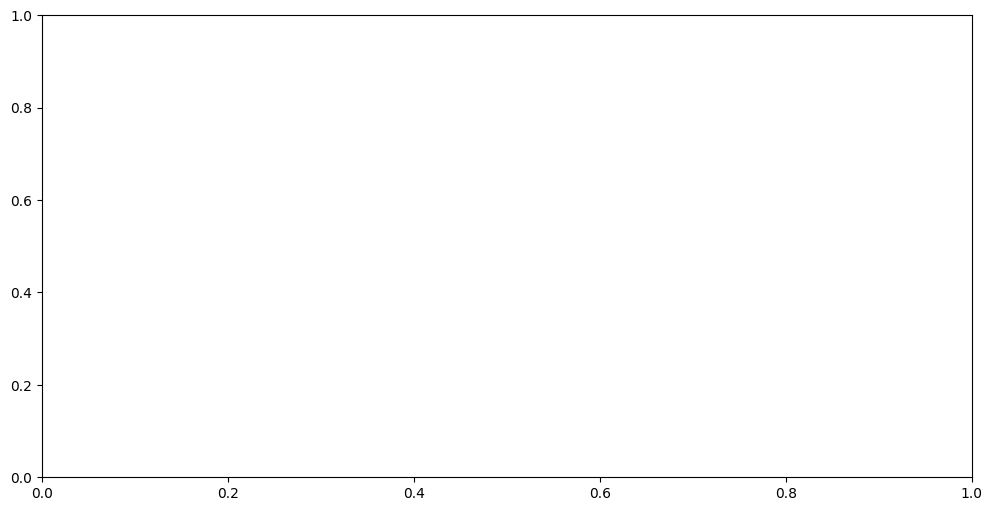

In [31]:
# Optionally, create a visualization of the comparison
def plot_final_comparison(all_models_stats):
    import matplotlib.pyplot as plt
    import numpy as np
    
    if not all_models_stats:
        return
        
    metrics = list(next(iter(all_models_stats.values())).keys())
    models = list(all_models_stats.keys())
    n_metrics = len(metrics)
    n_models = len(models)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    x = np.arange(n_metrics)
    width = 0.8 / n_models
    
    for i, model in enumerate(models):
        means = [all_models_stats[model][metric]['mean'] for metric in metrics]
        errs = [all_models_stats[model][metric]['std_error'] for metric in metrics]
        
        # Calculate 95% confidence intervals
        conf_intervals = []
        for mean, err in zip(means, errs):
            # For 95% CI, multiply standard error by 1.96
            conf_interval = 1.96 * err
            conf_intervals.append(conf_interval)
        
        ax.bar(x + i*width - width*n_models/2, means, width,
               label=model.split('/')[-1],
               yerr=conf_intervals, capsize=5)
        
        # Add confidence interval bounds as text
        for j, (mean, ci) in enumerate(zip(means, conf_intervals)):
            lower = mean - ci
            upper = mean + ci
            # Print upper limit above error bar
            ax.text(x[j] + i*width - width*n_models/2, mean + ci + 0.01,
                   f'{upper:.3f}', ha='center', va='bottom', fontsize=8)
            # Print lower limit below error bar
            ax.text(x[j] + i*width - width*n_models/2, mean - ci - 0.01,
                   f'{lower:.3f}', ha='center', va='top', fontsize=8)
    
    ax.set_ylabel('Score')
    ax.set_title('Metric Comparison Across Models\nwith 95% Confidence Intervals')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics, rotation=45)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.savefig('model_comparison.png', bbox_inches='tight')
    plt.show()
    plt.close()

# Create the comparison plot
plot_final_comparison(all_models_stats)

In [32]:
def perform_paired_analysis(all_runs_model_metrics):
    """
    Performs paired t-tests between all pairs of models for each metric.
    
    Args:
        all_runs_model_metrics: Dictionary with model IDs as keys and lists of metric scores as values
    Returns:
        Dictionary containing pairwise comparison results
    """
    from scipy import stats
    import numpy as np
    
    # Store results
    comparison_results = {}
    
    # Get all model pairs
    model_pairs = list(itertools.combinations(all_runs_model_metrics.keys(), 2))
    
    for model1, model2 in model_pairs:
        comparison_key = f"{model1}_vs_{model2}"
        comparison_results[comparison_key] = {}
        
        # Get metrics for both models
        metrics1 = all_runs_model_metrics[model1]
        metrics2 = all_runs_model_metrics[model2]
        
        # For each metric type
        for metric_name in list_of_metrics:
            metric_name = metric_name.replace('_descr', '')
            
            # Get all scores for this metric across resamples
            scores1 = []
            scores2 = []
            
            # Collect scores from all resamples
            for resample_metrics1, resample_metrics2 in zip(metrics1, metrics2):
                scores1.extend(resample_metrics1[metric_name + '_descr'])
                scores2.extend(resample_metrics2[metric_name + '_descr'])
            
            # Perform paired t-test
            t_stat, p_value = stats.ttest_rel(scores1, scores2)
            
            # Calculate effect size (Cohen's d)
            diff = np.array(scores1) - np.array(scores2)
            cohens_d = np.mean(diff) / np.std(diff, ddof=1)
            
            comparison_results[comparison_key][metric_name] = {
                "t_statistic": t_stat,
                "p_value": p_value,
                "effect_size": cohens_d,
                "significant": p_value < 0.05,
                "better_model": model1 if np.mean(scores1) > np.mean(scores2) else model2,
                "mean_diff": np.mean(scores1) - np.mean(scores2)
            }
            
            # Print results
            print(f"\nResults for {metric_name} - {model1} vs {model2}:")
            print(f"t-statistic: {t_stat:.4f}")
            print(f"p-value: {p_value:.4f}")
            print(f"Cohen's d: {cohens_d:.4f}")
            print(f"Mean difference: {np.mean(scores1) - np.mean(scores2):.4f}")
            print(f"Better model: {comparison_results[comparison_key][metric_name]['better_model']}")
            print(f"Statistically significant: {p_value < 0.05}")
    
    return comparison_results

In [33]:
# After all models have been evaluated
print("\nPerforming paired analysis between models...")
paired_analysis_results = perform_paired_analysis(all_runs_model_metrics)

# Optionally save results to file
import json
with open(f'paired_analysis_results_{judge_model.split("/")[1]}.json', 'w') as f:
    json.dump(paired_analysis_results, f, indent=4)


Performing paired analysis between models...

Results for completeness - anthropic/claude-3-5-sonnet-20241022 vs Qwen/Qwen2.5-7B-Instruct:
t-statistic: 3.8571
p-value: 0.0039
Cohen's d: 1.2197
Mean difference: 0.9000
Better model: anthropic/claude-3-5-sonnet-20241022
Statistically significant: True

Results for relevance - anthropic/claude-3-5-sonnet-20241022 vs Qwen/Qwen2.5-7B-Instruct:
t-statistic: 0.4286
p-value: 0.6783
Cohen's d: 0.1355
Mean difference: 0.1000
Better model: anthropic/claude-3-5-sonnet-20241022
Statistically significant: False

Results for conciseness - anthropic/claude-3-5-sonnet-20241022 vs Qwen/Qwen2.5-7B-Instruct:
t-statistic: 0.0000
p-value: 1.0000
Cohen's d: 0.0000
Mean difference: 0.0000
Better model: Qwen/Qwen2.5-7B-Instruct
Statistically significant: False

Results for confidence - anthropic/claude-3-5-sonnet-20241022 vs Qwen/Qwen2.5-7B-Instruct:
t-statistic: 1.2457
p-value: 0.2443
Cohen's d: 0.3939
Mean difference: 0.5000
Better model: anthropic/claude-3-

TypeError: Object of type bool_ is not JSON serializable

Create tables with num questions, model_ids in columns

In [ ]:
#Report average score per metric and std in parenthesis as percentage

Power Analysis

In [34]:
from statsmodels.stats.power import TTestIndPower

def perform_power_analysis(effect_size=0.5, alpha=0.05, power=0.8):
    """
    Perform power analysis to determine required sample size.
    
    Args:
        effect_size (float): Expected effect size (Cohen's d)
        alpha (float): Significance level
        power (float): Desired statistical power
        
    Returns:
        int: Required sample size per group
    """
    analysis = TTestIndPower()
    sample_size = analysis.solve_power(
        effect_size=effect_size,
        alpha=alpha,
        power=power,
        alternative='two-sided'
    )
    return int(np.ceil(sample_size))

# First, determine required sample size
required_samples = perform_power_analysis(effect_size=0.1254, alpha=0.05, power=0.8)  #These parameters result in a sample size of 1000
print(f"Required samples per model for statistical power: {required_samples}")

Required samples per model for statistical power: 1000


For real-time inference (below implementation only for meta-llama/Meta-Llama-3.1-8B-Instruct)

In [35]:
# from transformers import AutoModelForCausalLM, AutoTokenizer
# import torch
# # del pipeline #Otherwise too much memory is used

# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForCausalLM.from_pretrained(model_name,device_map='auto')

# #Example of real-time response generation
# messages=[{"role": "user", "content": "What is the chemical formula of water?"}]

# inputs_tokenized = tokenizer.apply_chat_template(
#     messages,
#     tokenize=True,
#     add_generation_prompt=True,
#     return_tensors="pt",
#     return_dict=True,
# ).to("cuda")

# input_ids = inputs_tokenized['input_ids']

# # Generate tokens one by one
# max_length = 256
# output_ids = input_ids
# for _ in range(256):
#     outputs = model.generate(
#         output_ids,
#         max_new_tokens=1,
#         do_sample=True,
#         top_k=50,
#         pad_token_id=tokenizer.eos_token_id
#     )
#     new_token_id = outputs[0, -1].item()
#     if new_token_id == tokenizer.eos_token_id:
#         break
#     output_ids = torch.cat([output_ids, outputs[:, -1:]], dim=1)
#     new_token = tokenizer.decode(new_token_id, skip_special_tokens=True)
#     print(new_token, end="", flush=True)

# print()

Other evaluators from Langsmith

In [36]:
# https://docs.smith.langchain.com/old/evaluation/faq/evaluator-implementations
# https://docs.smith.langchain.com/old/evaluation/quickstart

# from langsmith.evaluation import LangChainStringEvaluator

# eval_llm = ChatOpenAI(model_name=judge_model.split('/')[1], api_key=openai_api_key, temperature=0.0, seed=42)

# #Evaluators
# qa_evaluator = LangChainStringEvaluator("qa", config={"llm": eval_llm}) #LLM just gives 'correct' or 'incorrect' based on reference answer
# context_qa_evaluator = LangChainStringEvaluator("context_qa", config={"llm": eval_llm}) #Also uses reference context of example outputs to do the above
# cot_qa_evaluator = LangChainStringEvaluator("cot_qa", config={"llm": eval_llm}) #Same as above but with chain of thought 'reasoning'

#Prompts Used internally:

# 1) context_qa_evaluator: You are a teacher grading a quiz.
# You are given a question, the context the question is about, and the student's answer. You are asked to score the student's answer as either CORRECT or INCORRECT, 
# based on the context.

# Example Format:
# QUESTION: question here
# CONTEXT: context the question is about here
# STUDENT ANSWER: student's answer here
# GRADE: CORRECT or INCORRECT here

# Grade the student answers based ONLY on their factual accuracy. Ignore differences in punctuation and phrasing between the student answer and true answer. 
# It is OK if the student answer contains more information than the true answer, as long as it does not contain any conflicting statements. Begin! 


# 2) cot_qa_evaluator: You are a teacher grading a quiz.
# You are given a question, the context the question is about, and the student's answer. You are asked to score the student's answer as either CORRECT or INCORRECT, 
# based on the context.
# Write out in a step by step manner your reasoning to be sure that your conclusion is correct. Avoid simply stating the correct answer at the outset.

# Example Format:
# QUESTION: question here
# CONTEXT: context the question is about here
# STUDENT ANSWER: student's answer here
# EXPLANATION: step by step reasoning here
# GRADE: CORRECT or INCORRECT here

# Grade the student answers based ONLY on their factual accuracy. Ignore differences in punctuation and phrasing between the student answer and true answer.
#  It is OK if the student answer contains more information than the true answer, as long as it does not contain any conflicting statements. Begin! 


# 3) qa_evaluator: You are a teacher grading a quiz.
# You are given a question, the student's answer, and the true answer, and are asked to score the student answer as either CORRECT or INCORRECT.

# Example Format:
# QUESTION: question here
# STUDENT ANSWER: student's answer here
# TRUE ANSWER: true answer here
# GRADE: CORRECT or INCORRECT here

# Grade the student answers based ONLY on their factual accuracy. Ignore differences in punctuation and phrasing between the student answer and true answer.
#  It is OK if the student answer contains more information than the true answer, as long as it does not contain any conflicting statements. Begin! 

Alternatively, use custom prompts as shown below (and set {"prompt": PROMPT} as additional argument inside the config above)

In [37]:
# from langchain_core.prompts.prompt import PromptTemplate

# _PROMPT_TEMPLATE = """You are an expert professor specialized in chemical engineering answers to questions.
# You are grading the following question:
# {query}
# Here is the real answer:
# {answer}
# You are grading the following predicted answer:
# {result}
# Respond with CORRECT or INCORRECT:
# """

# PROMPT = PromptTemplate(
#     input_variables=["query", "result", "answer"], template=_PROMPT_TEMPLATE
# )

Notes: Non-reproducible results, even when seed set (https://platform.openai.com/docs/api-reference/chat/create#chat-create-seed), temperature=0 (top_p should not change when we changed temperature - smaller values result in more constrained and focused response - https://medium.com/@rasithbm/chatopenai-parameters-83bef49f6384)